In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score, classification_report
import torch

In [15]:
# Load the dataset
file_path = "/kaggle/input/iot-final-dataset/IotFinalDataset.csv"
df = pd.read_csv(file_path)
# List of least important columns to drop
columns_to_drop = [
    'Flow Packets/s', 'Bwd IAT Mean', 'Fwd Act Data Pkts', 'Flow IAT Std', 'Idle Std',
    'Packet Length Mean', 'Flow Bytes/s', 'PSH Flag Count', 'Bwd Packet Length Max',
    'Fwd Packet Length Max', 'Total Length of Fwd Packet', 'Flow Duration', 'Bwd Packet Length Min',
    'Flow IAT Max' , 'Packet Length Max' ,'SYN Flag Count',  'FWD Init Win Bytes', 'Bwd Init Win Bytes',
    'Fwd Packet Length Min'  , 'Bwd IAT Std'  , 'Active Std' , 'Idle Mean',
    'Total Fwd Packet', 'Fwd IAT Std', 'Bwd Bulk Rate Avg', 'Active Mean'
]

# Drop the columns from the DataFrame
df = df.drop(columns=columns_to_drop)

# Display first 5 rows
df.head()

df.to_csv("iot-model4.csv")

In [16]:
# Assuming 'label' is the target column
target_column = 'Label'

# Select all columns except the target
features = [col for col in df.columns if col != target_column]

# Convert categorical labels to numerical values
label_encoder = LabelEncoder()
df[target_column] = label_encoder.fit_transform(df[target_column])


In [17]:
from sklearn.preprocessing import StandardScaler

# Convert all columns to numeric (useful if there are mixed data types)
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

# Standardize numerical features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [18]:
# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target_column], test_size=0.2, random_state=42)

# Convert to NumPy arrays (required for TabNet)
X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
y_train, y_test = y_train.to_numpy(), y_test.to_numpy()


In [19]:
# Initialize TabNet Classifier
tabnet_clf = TabNetClassifier()
# Train the model
tabnet_clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    max_epochs=50,
    patience=10,
    batch_size=1024
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.17146 | val_0_accuracy: 0.96505 |  0:00:53s
epoch 1  | loss: 0.10806 | val_0_accuracy: 0.97023 |  0:01:47s
epoch 2  | loss: 0.10051 | val_0_accuracy: 0.81362 |  0:02:41s
epoch 3  | loss: 0.09672 | val_0_accuracy: 0.79046 |  0:03:36s
epoch 4  | loss: 0.09476 | val_0_accuracy: 0.84186 |  0:04:30s
epoch 5  | loss: 0.09946 | val_0_accuracy: 0.92407 |  0:05:24s
epoch 6  | loss: 0.07148 | val_0_accuracy: 0.75475 |  0:06:19s
epoch 7  | loss: 0.0643  | val_0_accuracy: 0.91152 |  0:07:13s
epoch 8  | loss: 0.07213 | val_0_accuracy: 0.96479 |  0:08:06s
epoch 9  | loss: 0.07134 | val_0_accuracy: 0.97398 |  0:09:00s
epoch 10 | loss: 0.06872 | val_0_accuracy: 0.81519 |  0:09:53s
epoch 11 | loss: 0.06575 | val_0_accuracy: 0.93238 |  0:10:47s
epoch 12 | loss: 0.06189 | val_0_accuracy: 0.92834 |  0:11:41s
epoch 13 | loss: 0.06068 | val_0_accuracy: 0.76135 |  0:12:34s
epoch 14 | loss: 0.05717 | val_0_accuracy: 0.85978 |  0:13:28s
epoch 15 | loss: 0.05397 | val_0_accuracy: 0.98153 |  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [20]:
# Predict on test set
y_pred = tabnet_clf.predict(X_test)

In [21]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.9889

Classification Report:
                    precision    recall  f1-score   support

            Benign       0.99      0.97      0.98     65391
         DNS Flood       0.97      0.99      0.98      9338
 Dictionary Attack       0.98      1.00      0.99      2013
        ICMP Flood       1.00      1.00      1.00     44930
           OS Scan       0.99      0.95      0.97      7700
        Ping Sweep       0.95      0.99      0.97     14358
         Port Scan       0.99      1.00      1.00     88162
         SYN Flood       0.92      1.00      0.96      2817
         Slowloris       0.99      1.00      1.00      3724
         UDP Flood       0.89      0.97      0.93      2015
Vulnerability Scan       0.99      0.99      0.99      8015

          accuracy                           0.99    248463
         macro avg       0.97      0.99      0.98    248463
      weighted avg       0.99      0.99      0.99    248463



In [22]:
import joblib
from sklearn.preprocessing import StandardScaler

# Save the trained model
joblib.dump(tabnet_clf, "tabnet_model.pkl")

# Save the StandardScaler
joblib.dump(scaler, "scaler.pkl")

print("Model and scaler saved successfully!")

Model and scaler saved successfully!


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     65391
           1       0.97      0.99      0.98      9338
           2       0.98      1.00      0.99      2013
           3       1.00      1.00      1.00     44930
           4       0.99      0.95      0.97      7700
           5       0.95      0.99      0.97     14358
           6       0.99      1.00      1.00     88162
           7       0.92      1.00      0.96      2817
           8       0.99      1.00      1.00      3724
           9       0.89      0.97      0.93      2015
          10       0.99      0.99      0.99      8015

    accuracy                           0.99    248463
   macro avg       0.97      0.99      0.98    248463
weighted avg       0.99      0.99      0.99    248463

Accuracy: 0.9889


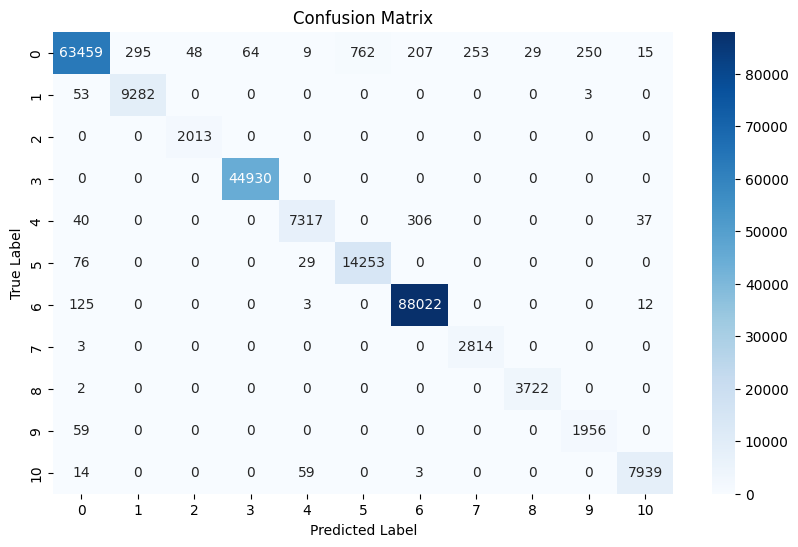

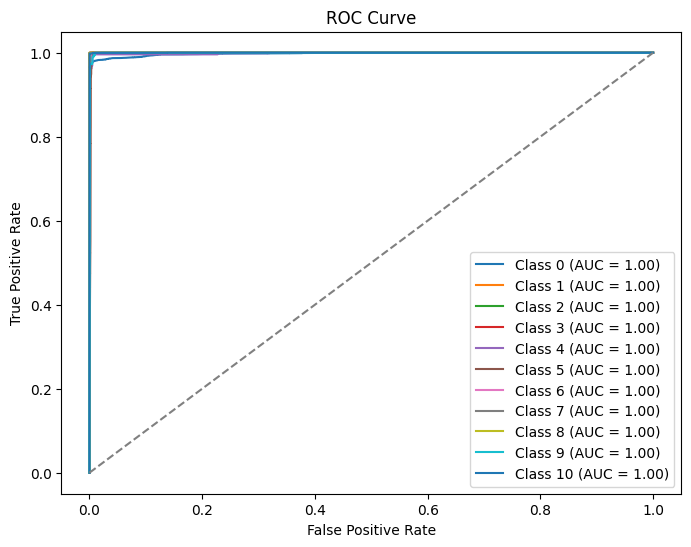

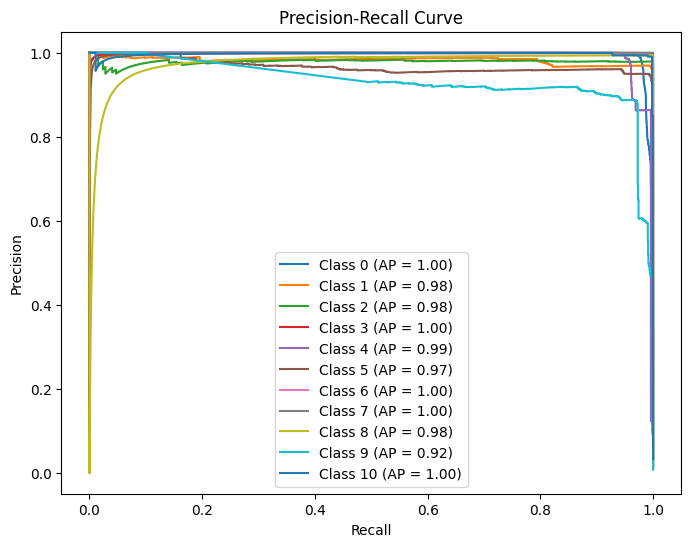

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize

# Define class labels properly
class_labels = np.unique(y_test)  # Extract unique labels from y_test

# --- 1️⃣ Classification Report ---
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  # Fix undefined metric issue

# --- 2️⃣ Accuracy Score ---
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# --- 3️⃣ Confusion Matrix ---
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# --- 4️⃣ ROC Curve (for multi-class) ---
y_test_bin = label_binarize(y_test, classes=class_labels)
y_pred_proba = tabnet_clf.predict_proba(X_test)  # Ensure you use probability outputs

plt.figure(figsize=(8, 6))
for i, label in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# --- 5️⃣ Precision-Recall Curve ---
plt.figure(figsize=(8, 6))
for i, label in enumerate(class_labels):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
    ap_score = average_precision_score(y_test_bin[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'Class {label} (AP = {ap_score:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

            Feature  Importance
1     Flow IAT Mean    0.000000
2    FIN Flag Count    0.000000
0          Protocol    0.017269
3    RST Flag Count    0.025584
4     Down/Up Ratio    0.111698
7   Connection Type    0.235780
6          Idle Max    0.290322
5  Fwd Seg Size Min    0.319347


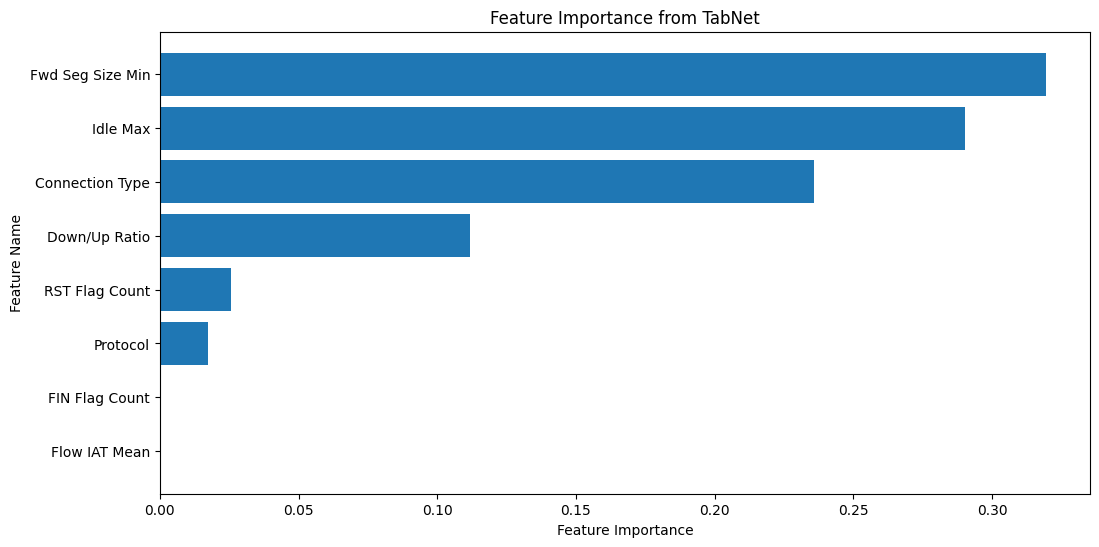

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance from the trained model
feature_importance = tabnet_clf.feature_importances_

# Create a DataFrame to visualize feature importance
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=True)
print(importance_df)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance from TabNet')
plt.show()

# custom data prediction

In [28]:
joblib.dump(label_encoder, "/kaggle/working/label_encoder.pkl")

# Load the trained TabNet model
tabnet_model = joblib.load("/kaggle/working/tabnet_model.pkl")

# Load the saved StandardScaler
scaler = joblib.load("/kaggle/working/scaler.pkl")

# Load the Label Encoder (if needed, to decode class predictions)
label_encoder = joblib.load("/kaggle/working/label_encoder.pkl")  # If you saved it


In [33]:
# Define the feature names (MUST match training order)
feature_names = ["Protocol", "Flow IAT Mean", "FIN Flag Count", "RST Flag Count",
                 "Down/Up Ratio", "Fwd Seg Size Min", "Idle Max", "Connection Type"]

# Custom input values (ensure they match feature order)
custom_row = np.array([[0,	2934990,	0,	0,	0,	0,	1698846230732390 ,	1]])


# Standardize the custom row using the same scaler
custom_row_scaled = scaler.transform(custom_row)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [34]:
# Predict class label
predicted_label = tabnet_model.predict(custom_row_scaled)[0]

# Predict probabilities
predicted_probs = tabnet_model.predict_proba(custom_row_scaled)[0]

# Convert numerical prediction back to original label (if LabelEncoder is available)
decoded_label = label_encoder.inverse_transform([predicted_label])[0]

# Display results
print(f"Predicted Class: {decoded_label}")
print(f"Class Probabilities: {predicted_probs}")

Predicted Class: ICMP Flood
Class Probabilities: [4.0872679e-03 1.7603980e-26 1.3691516e-15 9.9591273e-01 5.5515807e-14
 2.6568339e-13 4.5402681e-16 1.7707799e-30 1.2298106e-24 1.3105766e-15
 1.7901477e-18]
